# Figures from flexible genome analysis

In [1]:
import pandas as pd, seaborn as sns, numpy as np
import matplotlib.pyplot as plt, matplotlib.ticker as ticker
import scipy.stats as stats
import itertools, os, random
import sklearn.preprocessing as preproc

sns.set_style('white')
%matplotlib inline

In [2]:
def strain_match_median(x, y):
    """
    Accepts x and y, which are some sort of iterable containing read depth information for
    different sections of the genome. Returns True if the strains are thought to be a match
    and False if the strains are thought to be a mismatch.
    
    Ignores any genome sections where both strains have zero coverage
    
    Strain matching is determined by identifying whether any regions are >= the median read
    depth in one sample while <= 1/1000th of the median read depth in the other sample.
    
    Returns True if the strains appear to match.
    """
    zipped = [[x, y] for x, y in zip(x, y) if x > 0 or y > 0]
    median_x = np.median([i[0] for i in zipped])
    median_y = np.median([i[1] for i in zipped])
    
    #first go through the first sample
    return_val = True
    for x_val, y_val in zipped:
        #check for matching
        if x_val >= median_x and y_val <= (median_y / 1000):
            return_val = False
            break
        elif y_val >= median_y and x_val <= (median_x / 1000):
            return_val = False
            break
    
    return return_val

In [3]:
def plot_freq_comp_hex(x_series, y_series, log_axes=True, bin_method=None,
                       gridsize=30, spearman=True):
    """
    Takes two series, which are assumed to be the same type of values and 
    plot the two against each other.
    
    The two series either must have identical indexes OR have indexes that
    are related, and thus comparison of each index is valid
    
    ONLY shared elements will be used for the plot and stats. Elements in
    one series that are abset from the other are ignored.
    
    Log will plot both axes using a log scale
    Spearman will report the # of shared elements, spearman rho, and p val
    Return axes will return the axes object
    """
    #merge series, removing missing values
    tmp_table = pd.concat([x_series, y_series], axis=1, join='inner')
    tmp_table = tmp_table.dropna() #drop nans
    
    #plotting parameters
    if log_axes:
        xscale = 'log'
        yscale = 'log'
    else:
        xscale = 'linear'
        yscale = 'linear'
    
    #plot_extents = (-7, -3, -7, -3)#hard set for plotting
    
    #start plotting
    plt.hexbin(tmp_table.iloc[:, 0].values, tmp_table.iloc[:, 1].values,
               gridsize=gridsize, cmap='PuBu', xscale=xscale, yscale=yscale, 
               bins=bin_method)#, extent=plot_extents)
    
    #plt.xlim(x_series.min(), x_series.max())
    #plt.ylim(y_series.min(), y_series.max())
    
    sns.despine()
    
    #calculate spearman correlation and report
    if spearman:
        rho, pval = stats.spearmanr(tmp_table.iloc[:, 0].values,
                                    tmp_table.iloc[:, 1].values)
        print('shared elements = {0}, rs = {1:.5f}, p = {2:.5f}'.format(len(tmp_table),
                                                                        rho,
                                                                        pval))

In [4]:
def read_flex_tables(directory, metadata):
    """
    Reads a directory of data files from flexible genome analysis into a dataframe
    """
    files = [x for x in os.listdir(directory) if x.endswith('.tsv.gz')]
    os.chdir(directory)
    
    #read in data tables
    dfs = []
    for file in files:
        dfs.append([file.split('_paired')[0],
                    pd.read_csv(file, sep='\t', compression='gzip')])

    #add samples information to each dataframe
    for sample, df in dfs:
        df.loc[:, 'sample_id'] = sample

    #merge these tables together
    df_klen = pd.concat([x[1] for x in dfs])

    #add metadata information
    df_klen = df_klen.merge(metadata[['sample_id', 'days_past_fmt', 'patient']])
    
    return df_klen

In [5]:
def strain_match_wrap(data_df, patient_comparisons):
    """
    Given a datatable of flexible genome read depth data and a pairing of patients
    and samples for comparison, return a dataframe with results of the strain matching
    protocol.
    
    patient_comparisons should be in the format:
    [[patient, sample_to_compare], [patient1, sample_to_compare1], ...]
    """
    results = []
    
    #go through each patient
    for patient, sample in patient_comparisons:
    #get sample pairs to consider
        patient_df = data_df.loc[data_df['patient'] == patient].sort_values(['days_past_fmt', 
                                                                             'sample_id'])
        patient_samples = list(patient_df['sample_id'].unique())
        sample_pairs = [[x, sample] for x in patient_samples]
    
        for x, y in sample_pairs:
            #get data for these samples
            df_x = data_df.loc[data_df['sample_id'] == x]
            df_y = data_df.loc[data_df['sample_id'] == y]
            if df_x.empty or df_y.empty:
                print("Error: one of the input dataframes is empty. Do not trust results")
            plot_df = df_x.merge(df_y, on=['contig', 'k_idx'], how='outer')
            #calculate strain matching
            thresh = strain_match_median(plot_df['median_read_depth_x'], 
                                         plot_df['median_read_depth_y'])
        
            results.append([patient, x, y, thresh])

    results_df = pd.DataFrame(results, columns=['patient', 'sample_x', 'sample_y',
                                                'median_thresh'])
    return results_df

In [6]:
def strain_match_plot(strain_match_df, axes=None):
    """
    Accepts a results dataframe from strain_match_wrap and plots
    """
    #add time information to table
    plot_df = strain_match_df.merge(md[['sample_id', 'days_past_fmt']], 
                                    left_on='sample_x', right_on='sample_id')
    
    #get a formatter table for plotting
    plot_df = plot_df.set_index('days_past_fmt')

    #make an index for where to place each patient's timeline
    patients = plot_df['patient'].unique()
    cat_dict = dict(zip(patients, range(1, len(patients) + 1)))
    val_dict = dict(zip(range(1, len(patients) + 1), patients))

    #get plotting row
    plot_df['row_num'] = plot_df['patient'].apply(cat_dict.get)
    
    #plot, using the x value as the time, the y value as the patient, and the thresh as the color
    if not axes:
        fig, axes = plt.subplots()
    
    #first let's plot the false points
    false_df = plot_df.loc[plot_df['median_thresh'] == False]
    if not false_df.empty:
        false_df['row_num'].plot(ax=axes, style='rs', markersize=4)
    #now true points
    true_df = plot_df.loc[plot_df['median_thresh'] == True]
    if not true_df.empty:
        true_df['row_num'].plot(ax=axes, style='gs', markersize=4)
    
    #pad axes
    axes.margins(0.1)
    
    # format y-ticks look up the categories
    axes.set_xticklabels([])
    axes.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: val_dict.get(x)))
    y_ticks = axes.yaxis.get_major_ticks()
    y_ticks[0].label1.set_visible(False)
    y_ticks[-1].label1.set_visible(False)
    
    #add vertical lines for fmt
    axes.axvline(0, linestyle='--')
    
    sns.despine()

In [7]:
#read in metadata
md = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_stooldna_SP192018.tsv',
                 sep='\t', dtype={'patient': 'object',
                                  'fmt': 'object'})

#read in patient metadata
md_pat = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_patients_2019-04-10.tsv',
                     sep='\t', dtype={'patient': 'object',
                                      'fmt': 'object',
                                      'fmt_induction': 'object'})

In [8]:
#set up to read in data tables
ncbi_dir = '/Users/ndchu/Documents/uc_fmt/metagenomics/strains_flexible/ncbi_ref_flex/'

fp_dir = '/Users/ndchu/Documents/uc_fmt/metagenomics/strains_flexible/ncbi_ref_flex/faecalibacterium_prausnitzii_GCF_000162015/k_len'
fp_files = os.listdir(fp_dir)
os.chdir(fp_dir)

In [9]:
#read in data tables
dfs_fp = []
for file in fp_files:
    dfs_fp.append([file.split('_paired')[0],
                   pd.read_csv(file, sep='\t', compression='gzip')])

#add sample information to each dataframe
for sample, df in dfs_fp:
    df.loc[:, 'sample_id'] = sample

#merge these tables together
df_klen_fp = pd.concat([x[1] for x in dfs_fp])

#add metadata information
df_klen_fp = df_klen_fp.merge(md[['sample_id', 'days_past_fmt']])

## Example plots from the donors

Let's start by making two pairs of plots, one from two samples from the same donor and another from two samples from different donors.

We'll focus on Faecalibacterium for now.

In [10]:
#we'll define a method to remove outliers to better plot these plots.
#this is taken from https://github.com/joferkington/oost_paper_code/blob/master/utilities.py
def mad_outlier(points, thresh=4):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise based on the median absolute deviation.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [11]:
def klen_df_fmt(df_klen, sample_1, sample_2, **kwargs):
    """
    Returns a merged dataframe ready for plotting.
    Filters for zeros and outliers.
    """
    #merge tables
    df_x = df_klen.loc[df_klen['sample_id'] == sample_1]
    df_y = df_klen.loc[df_klen['sample_id'] == sample_2]
    plot_df = df_x.merge(df_y, on=['contig', 'k_idx'])
    #remove zeros
    plot_df = plot_df.loc[(plot_df['median_read_depth_x'] > 0) | \
                          (plot_df['median_read_depth_y'] > 0)]
    #remove outliers
    plot_df = plot_df.loc[(~mad_outlier(plot_df['median_read_depth_x'])) & \
                          (~mad_outlier(plot_df['median_read_depth_y']))]
    return plot_df

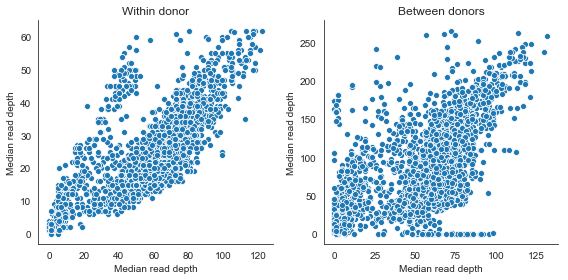

In [13]:
#plot standard scatterplots
fig = plt.figure(figsize = (8,4))

x = '0044-0076'
y = '0044-0101'
z = '0073-0014'

#plot two donor samples from same donor
ax1 = fig.add_subplot(1,2,1)

#format data
plot_df = klen_df_fmt(df_klen_fp, x, y)

sns.scatterplot(x='median_read_depth_x', y='median_read_depth_y',
                data=plot_df)

#format axes
#ax1.set_xlim(0, 170)
#ax1.set_xscale('symlog')
ax1.set_xlabel('Median read depth')
ax1.set_ylabel('Median read depth')
ax1.set_title('Within donor')

ax2 = fig.add_subplot(1,2,2)

#format data
plot_df = klen_df_fmt(df_klen_fp, x, z)

sns.scatterplot(x='median_read_depth_x', y='median_read_depth_y',
                data=plot_df)

ax2.set_xlabel('Median read depth')
ax2.set_ylabel('Median read depth')
ax2.set_title('Between donors')

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_scatter_donorex_SP202018.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_scatter_donorex_SP202018.pdf',
            dpi=300)

shared elements = 2767, rs = 0.77824, p = 0.00000
shared elements = 2874, rs = 0.61557, p = 0.00000


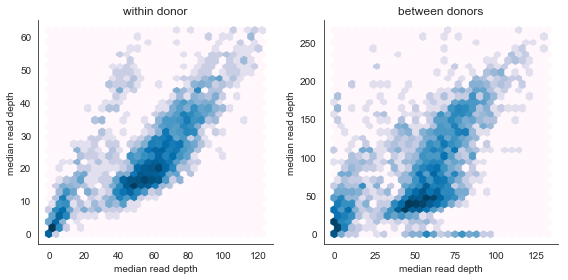

In [46]:
#do the same plots but hexbins
fig = plt.figure(figsize = (8,4))

x = '0044-0076'
y = '0044-0101'
z = '0073-0014'

#plot two donor samples from same donor
ax1 = fig.add_subplot(1,2,1)

#format data
plot_df = klen_df_fmt(df_klen_fp, x, y)

plot_freq_comp_hex(plot_df['median_read_depth_x'],
                   plot_df['median_read_depth_y'],
                   log_axes=False, bin_method='log')

#format axes
#ax1.set_xlim(0, 170)
#ax1.set_xscale('symlog')
ax1.set_xlabel('median read depth')
ax1.set_ylabel('median read depth')
ax1.set_title('within donor')

ax2 = fig.add_subplot(1,2,2)

#format data
plot_df = klen_df_fmt(df_klen_fp, x, z)

plot_freq_comp_hex(plot_df['median_read_depth_x'],
                   plot_df['median_read_depth_y'],
                   log_axes=False, bin_method='log')

ax2.set_xlabel('median read depth')
ax2.set_ylabel('median read depth')
ax2.set_title('between donors')

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_hexbin_donorex_SP202018.png',
            dpi=300)

### Looking more closely at less abundant organisms

In [16]:
#set up to read in data tables
ncbi_dir = '/Users/ndchu/Documents/uc_fmt/metagenomics/strains_flexible/ncbi_ref_flex/'

blo_dir = '/Users/ndchu/Documents/uc_fmt/metagenomics/strains_flexible/ncbi_ref_flex/blautia_obeum_GCF_000153905/k_len'
blo_files = os.listdir(blo_dir)
os.chdir(blo_dir)

#read in data tables
dfs_blo = []
for file in blo_files:
    dfs_blo.append([file.split('_paired')[0],
                   pd.read_csv(file, sep='\t', compression='gzip')])

#add sample information to each dataframe
for sample, df in dfs_blo:
    df.loc[:, 'sample_id'] = sample

#merge these tables together
df_klen_blo = pd.concat([x[1] for x in dfs_blo])

#add metadata information
df_klen_blo = df_klen_blo.merge(md[['sample_id', 'days_past_fmt']])

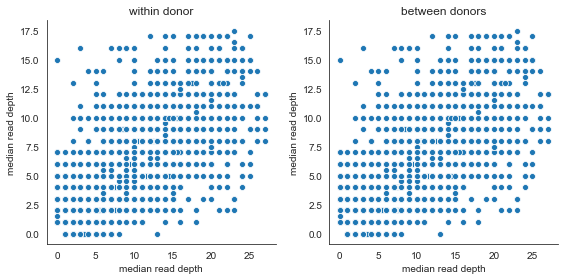

In [59]:
#plot standard scatterplots
fig = plt.figure(figsize = (8,4))

x = 'BB0000001331'
y = '03-246'
z = 'BB0000001358'

#plot two donor samples from same donor
ax1 = fig.add_subplot(1,2,1)

#format data
plot_df = klen_df_fmt(df_klen_blo, x, y)

sns.scatterplot(x='median_read_depth_x', y='median_read_depth_y',
                data=plot_df)

#format axes
#ax1.set_xlim(0, 170)
#ax1.set_xscale('symlog')
ax1.set_xlabel('median read depth')
ax1.set_ylabel('median read depth')
ax1.set_title('within donor')

ax2 = fig.add_subplot(1,2,2)

#format data
plot_df = klen_df_fmt(df_klen_blo, x, y)

sns.scatterplot(x='median_read_depth_x', y='median_read_depth_y',
                data=plot_df)

ax2.set_xlabel('median read depth')
ax2.set_ylabel('median read depth')
ax2.set_title('between donors')

sns.despine()
plt.tight_layout()

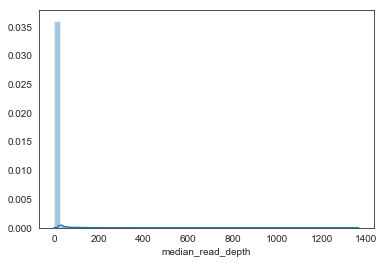

In [52]:
sns.distplot(df_klen_blo['median_read_depth'])

## Plots for Faecalibacterium

In [40]:
#patients with their donor induction samples
induction_pairs = [['001', '0044-0076'],
                   ['007', '0044-0115'],
                   ['008', '0073-0028'],
                   ['010', '0044-0157'],
                   ['011', '0073-0028'],
                   ['014', '0044-0169']]

#We'll also have a set of placebo controls for comparison
controls = [['004', '0044-0076'],
            ['005', '0044-0115'],
            ['006', '0073-0028'],
            ['009', '0044-0157'],
            ['012', '0073-0028'],
            ['013', '0044-0169']]

#and look at the switch FMT samples
switch_pairs = [['001', '0073-0032'],
                ['010', '0073-0034'],
                ['011', '0044-0126'],
                ['014', '0073-0014']]

#look at baseline samples as well for fmt patients
baseline_fmt_pairs = [['001', '03-178'],
                      ['001', '03-227'],
                      ['007', '007_screen'],
                      ['007', '03-328'],
                      ['007', '03-124'],
                      ['008', '008_screen'],
                      ['008', '03-180'],
                      ['008', '03-262'],
                      ['010', '010_screen'],
                      ['010', '03-129'],
                      ['010', '03-358'],
                      ['011', '011_screen'],
                      ['011', '03-315'],
                      ['011', '03-128'],
                      ['014', '014_screen'],
                      ['014', 'BB0000001329'],
                      ['014', 'BB0000001353']]

#and baseline for placebo
baseline_plc_pairs = [['004', '03-195'],
                      ['004', '03-138'],
                      ['005', '03-162'],
                      ['005', '03-265'],
                      ['006', '03-250'],
                      ['006', '03-246'],
                      ['009', '009_screen'],
                      ['009', '03-123'],
                      ['009', '03-341'],
                      ['012', 'BB0000001267'],
                      ['012', 'BB0000001273'],
                      ['013', '013_screen'],
                      ['013', 'BB0000001311'],
                      ['013', 'BB0000001264']]

In [13]:
ncbi_dir = '/Users/ndchu/Documents/uc_fmt/metagenomics/strains_flexible/ncbi_ref_flex/'

#get lists of genomes with their corresponding data directories
ncbi_genomes = [x for x in os.listdir(ncbi_dir) if not x.startswith('.')]
ncbi_genomes_data = [[x, ncbi_dir + x + '/k_len/'] for x in ncbi_genomes]

In [14]:
#now get dataframes for every genome for plot #1
#structure is [[genome, df], [genome, df]]
ncbi_data_dfs = [[x, read_flex_tables(y, md)] for x, y in ncbi_genomes_data]

In [15]:
#identify strain matches for induction FMT comparisons
ncbi_induc_match_dfs = [[x, strain_match_wrap(y, induction_pairs)] for x, y in ncbi_data_dfs]

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
#look at strain matches in the controls
ncbi_ctrl_match_dfs = [[x, strain_match_wrap(y, controls)] for x, y in ncbi_data_dfs]

In [23]:
#look at strain matches in the fmt versus baseline
ncbi_fmtbl_dfs = [[x, strain_match_wrap(y, baseline_fmt_pairs)] for x, y in ncbi_data_dfs]

In [26]:
#look at strain matches in the placebo versus baseline
ncbi_plcbl_dfs = [[x, strain_match_wrap(y, baseline_plc_pairs)] for x, y in ncbi_data_dfs]

Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one

Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one

Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one

Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one

In [61]:
fp_induc_match_df = ncbi_induc_match_dfs[11][1]

<Figure size 360x216 with 0 Axes>

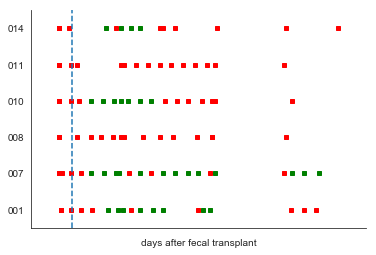

In [74]:
#plot the induction sample data
fig = plt.figure(figsize = (5,3))

strain_match_plot(fp_induc_match_df)

plt.xlabel('days after fecal transplant')

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_induc_SP202018.png',
            dpi=300)

In [73]:
fp_crtl_match_df = ncbi_ctrl_match_dfs[11][1]

<Figure size 360x216 with 0 Axes>

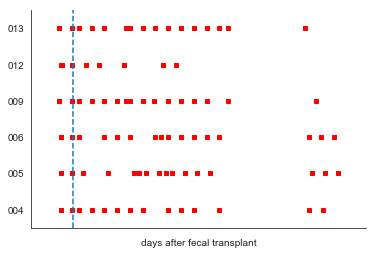

In [76]:
#plot the control sample data
fig = plt.figure(figsize = (5,3))

strain_match_plot(fp_crtl_match_df)

plt.xlabel('days after fecal transplant')

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_control_SP202018.png',
            dpi=300)

<Figure size 360x216 with 0 Axes>

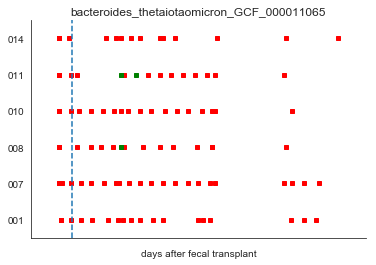

In [19]:
#plot the induction sample data
fig = plt.figure(figsize = (5,3))

strain_match_plot(ncbi_induc_match_dfs[1][1])

plt.xlabel('days after fecal transplant')
plt.title(ncbi_induc_match_dfs[1][0])

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_induc_btheta_SP202018.png',
            dpi=300)

<Figure size 360x216 with 0 Axes>

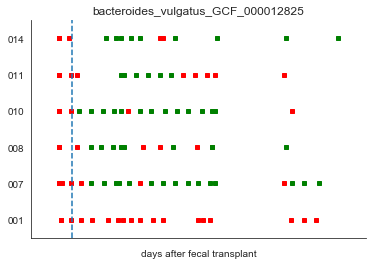

In [22]:
#plot the induction sample data
fig = plt.figure(figsize = (5,3))

strain_match_plot(ncbi_induc_match_dfs[4][1])

plt.xlabel('days after fecal transplant')
plt.title(ncbi_induc_match_dfs[4][0])

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_induc_bvulg_SP202018.png',
            dpi=300)

<Figure size 360x216 with 0 Axes>

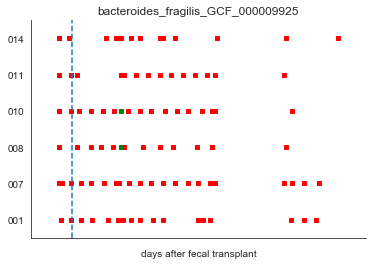

In [23]:
#plot the induction sample data
fig = plt.figure(figsize = (5,3))

strain_match_plot(ncbi_induc_match_dfs[5][1])

plt.xlabel('days after fecal transplant')
plt.title(ncbi_induc_match_dfs[5][0])

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_induc_bfrag_SP202018.png',
            dpi=300)

<Figure size 360x216 with 0 Axes>

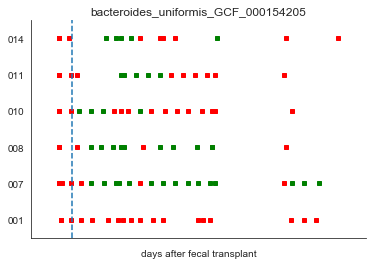

In [25]:
#plot the induction sample data
fig = plt.figure(figsize = (5,3))

strain_match_plot(ncbi_induc_match_dfs[7][1])

plt.xlabel('days after fecal transplant')
plt.title(ncbi_induc_match_dfs[7][0])

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_induc_bunif_SP202018.png',
            dpi=300)

<Figure size 360x216 with 0 Axes>

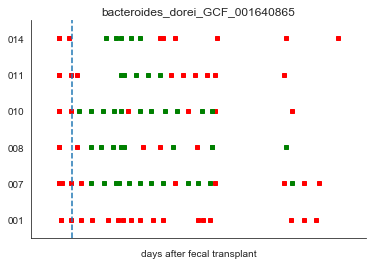

In [27]:
#plot the induction sample data
fig = plt.figure(figsize = (5,3))

strain_match_plot(ncbi_induc_match_dfs[12][1])

plt.xlabel('days after fecal transplant')
plt.title(ncbi_induc_match_dfs[12][0])

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_induc_bdor_SP202018.png',
            dpi=300)

<Figure size 360x216 with 0 Axes>

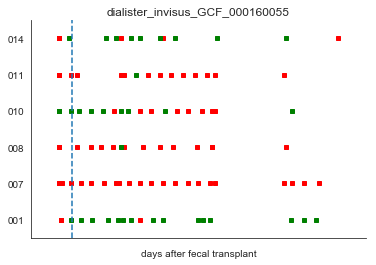

In [28]:
#plot the induction sample data
fig = plt.figure(figsize = (5,3))

strain_match_plot(ncbi_induc_match_dfs[14][1])

plt.xlabel('days after fecal transplant')
plt.title(ncbi_induc_match_dfs[14][0])

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_induc_dinv_SP202018.png',
            dpi=300)

<Figure size 360x216 with 0 Axes>

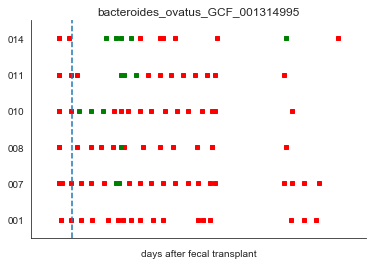

In [29]:
#plot the induction sample data
fig = plt.figure(figsize = (5,3))

strain_match_plot(ncbi_induc_match_dfs[15][1])

plt.xlabel('days after fecal transplant')
plt.title(ncbi_induc_match_dfs[15][0])

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_induc_bova_SP202018.png',
            dpi=300)

<Figure size 360x216 with 0 Axes>

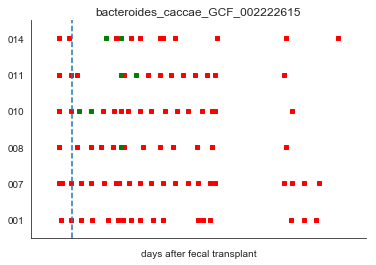

In [30]:
#plot the induction sample data
fig = plt.figure(figsize = (5,3))

strain_match_plot(ncbi_induc_match_dfs[16][1])

plt.xlabel('days after fecal transplant')
plt.title(ncbi_induc_match_dfs[16][0])

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_induc_bcac_SP202018.png',
            dpi=300)

## Making better looking plots

In [18]:
def strain_match_median2(x, y):
    """
    Accepts x and y, which are some sort of iterable containing read depth information for
    different sections of the genome. Returns 1 if the strains are thought to be a match, 
    -1 if the strains are thought to be a mismatch, and 0 if there is insufficient coverage.
    
    Ignores any genome sections where both strains have zero coverage
    
    Strain matching is determined by identifying whether any regions are >= the median read
    depth in one sample while <= 1/1000th of the median read depth in the other sample.
    """
    zipped = [[x, y] for x, y in zip(x, y) if x > 0 or y > 0]
    median_x = np.median([i[0] for i in zipped])
    median_y = np.median([i[1] for i in zipped])
    
    #set default as undefined
    return_val = 0
    
    #check for sufficient coverage
    if median_x < 5 or median_y < 5:
        #print("The read depth and coverage is too low")
        return_val = 0
    elif np.isnan(median_x) or np.isnan(median_y):
        #print("The read depth and coverage is too low")
        return_val = 0
    else:
        for x_val, y_val in zipped:
            #check for matching
            if x_val >= median_x and y_val <= (median_y / 1000):
                return_val = -1
                return return_val
            elif y_val >= median_y and x_val <= (median_x / 1000):
                return_val = -1
                return return_val
        return_val = 1
    
    return return_val

In [16]:
def strain_match_wrap2(data_df, patient_comparisons):
    """
    Given a datatable of flexible genome read depth data and a pairing of patients
    and samples for comparison, return a dataframe with results of the strain matching
    protocol.
    
    patient_comparisons should be in the format:
    [[patient, sample_to_compare], [patient1, sample_to_compare1], ...]
    """
    results = []
    
    #go through each patient
    for patient, sample in patient_comparisons:
    #get sample pairs to consider
        patient_df = data_df.loc[data_df['patient'] == patient].sort_values(['days_past_fmt', 
                                                                             'sample_id'])
        patient_samples = list(patient_df['sample_id'].unique())
        sample_pairs = [[x, sample] for x in patient_samples]
    
        for x, y in sample_pairs:
            #get data for these samples
            df_x = data_df.loc[data_df['sample_id'] == x]
            df_y = data_df.loc[data_df['sample_id'] == y]
            if df_x.empty or df_y.empty:
                print("Error: one of the input dataframes is empty. Do not trust results")
            plot_df = df_x.merge(df_y, on=['contig', 'k_idx'], how='outer')
            #calculate strain matching
            thresh = strain_match_median2(plot_df['median_read_depth_x'], 
                                          plot_df['median_read_depth_y'])
        
            results.append([patient, x, y, thresh])

    results_df = pd.DataFrame(results, columns=['patient', 'sample_x', 'sample_y',
                                                'median_thresh'])
    return results_df

In [18]:
def strain_match_plot2(strain_match_df, axes=None):
    """
    Accepts a results dataframe from strain_match_wrap and plots
    """
    #add time information to table
    plot_df = strain_match_df.merge(md[['sample_id', 'days_past_fmt']], 
                                    left_on='sample_x', right_on='sample_id')
    
    #get a formatter table for plotting
    plot_df = plot_df.set_index('days_past_fmt')

    #make an index for where to place each patient's timeline
    patients = plot_df['patient'].unique()
    cat_dict = dict(zip(patients, range(1, len(patients) + 1)))
    val_dict = dict(zip(range(1, len(patients) + 1), patients))

    #get plotting row
    plot_df['row_num'] = plot_df['patient'].apply(cat_dict.get)
    
    #plot, using the x value as the time, the y value as the patient, and the thresh as the color
    if not axes:
        fig, axes = plt.subplots()
    
    #first plot the ambiguous points
    amb_df = plot_df.loc[plot_df['median_thresh'] == 0]
    if not amb_df.empty:
        amb_df['row_num'].plot(ax=axes, markersize=5, 
                               color='#d9d9d9', linestyle="None", 
                               marker='o')
    #now plot the false points
    false_df = plot_df.loc[plot_df['median_thresh'] == -1]
    if not false_df.empty:
        false_df['row_num'].plot(ax=axes, color='#cf1717', 
                                 markersize=5, marker='o',
                                linestyle="None")
    #now true points
    true_df = plot_df.loc[plot_df['median_thresh'] == 1]
    if not true_df.empty:
        true_df['row_num'].plot(ax=axes, color='#0f8a4d', 
                                markersize=5, marker='o',
                                linestyle="None")
    
    #pad axes
    axes.margins(0.1)
    
    #axes.set_xticklabels([])
    
    # format y-ticks look up the categories
    axes.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: val_dict.get(x)))
    #y_ticks = axes.yaxis.get_major_ticks()
    #y_ticks[0].label1.set_visible(False)
    #y_ticks[-1].label1.set_visible(False)
    plt.locator_params(axis='y', nbins=6)
    
    #add vertical lines for fmt
    axes.axvline(0, linestyle='--')
    
    sns.despine()

In [17]:
#define a dictionary of patient names
patient_ids = md_pat.set_index('patient').to_dict()['label_pub']

def strain_match_plot3(strain_match_df, axes=None):
    """
    Accepts a results dataframe from strain_match_wrap and plots
    
    Green = strain match
    Red = bacteria absent
    Grey = strain identity ambiguous
    """
    #add time information to table
    plot_df = strain_match_df.merge(md[['sample_id', 'days_past_fmt']], 
                                    left_on='sample_x', right_on='sample_id')
    
    #get a formatter table for plotting
    plot_df = plot_df.set_index('days_past_fmt')

    #make an index for where to place each patient's timeline
    patients = plot_df['patient'].unique()
    ids = [patient_ids[x] for x in patients]
    cat_dict = dict(zip(patients, range(1, len(patients) + 1)))
    val_dict = dict(zip(range(1, len(patients) + 1), ids))

    #get plotting row
    plot_df['row_num'] = plot_df['patient'].apply(cat_dict.get)
    
    #plot, using the x value as the time, the y value as the patient, and the thresh as the color
    if not axes:
        fig, axes = plt.subplots()
    
    #first plot the ambiguous points
    amb_df = plot_df.loc[plot_df['median_thresh'] == 0]
    if not amb_df.empty:
        amb_df['row_num'].plot(ax=axes, markersize=5, 
                               color='#cf1717', linestyle="None", 
                               marker='o')
    #now plot the false points
    false_df = plot_df.loc[plot_df['median_thresh'] == -1]
    if not false_df.empty:
        false_df['row_num'].plot(ax=axes, color='#d9d9d9', 
                                 markersize=5, marker='o',
                                linestyle="None")
    #now true points
    true_df = plot_df.loc[plot_df['median_thresh'] == 1]
    if not true_df.empty:
        true_df['row_num'].plot(ax=axes, color='#0f8a4d', 
                                markersize=5, marker='o',
                                linestyle="None")
    
    #pad axes
    axes.margins(0.1)
    
    #axes.set_xticklabels([])
    
    # format y-ticks look up the categories
    axes.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: val_dict.get(x)))
    #y_ticks = axes.yaxis.get_major_ticks()
    #y_ticks[0].label1.set_visible(False)
    #y_ticks[-1].label1.set_visible(False)
    plt.locator_params(axis='y', nbins=6)
    
    #add vertical lines for fmt
    axes.axvline(0, linestyle='--')
    
    sns.despine()

In [22]:
#identify strain matches with these dataframes
ncbi_induc_match_dfs = [[x, strain_match_wrap2(y, induction_pairs)] for x, y in ncbi_data_dfs]

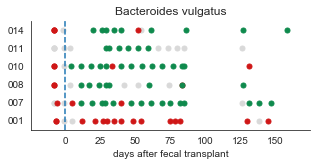

In [84]:
#plot the induction sample data
fig = plt.figure(figsize = (5,2))

ax = fig.add_subplot(111)

strain_match_plot2(ncbi_induc_match_dfs[4][1], axes=ax)

plt.xlabel('Days after fecal transplant')
plt.title('Bacteroides vulgatus')

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_induc_bvulg_NV272018.pdf')
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_induc_bvulg_NV272018.png',
            dpi=300)

In [25]:
gens = [x[0] for x in ncbi_induc_match_dfs]
genome_dict = {k: ' '.join(k.split('_')[:2]).capitalize() for k in gens}

NameError: name 'ncbi_induc_match_dfs' is not defined

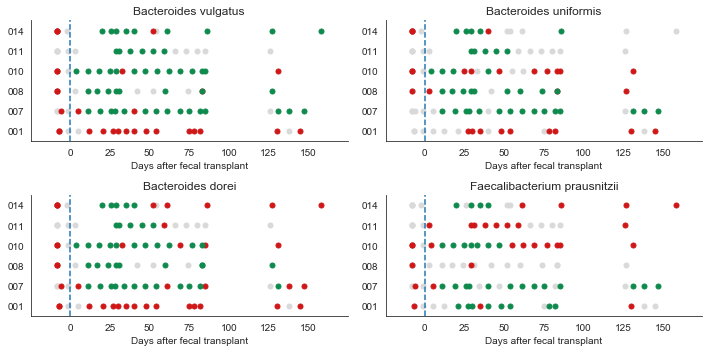

In [96]:
#plot stronger engrafters

ncbi_induc_match_dfs_eng = [ncbi_induc_match_dfs[x] for x in [4, 7, 12, 11]]

fig = plt.figure(figsize = (10,5))

counter = 1
for genome, df in ncbi_induc_match_dfs_eng:
    ax = fig.add_subplot(2, 2, counter)
    
    strain_match_plot2(df, axes=ax)

    plt.xlabel('Days after fecal transplant')
    plt.title(genome_dict[genome])
    
    counter += 1

plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_engrafters_2019-04-13.pdf')
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_engrafters_2019-04-13.png',
            dpi=300)

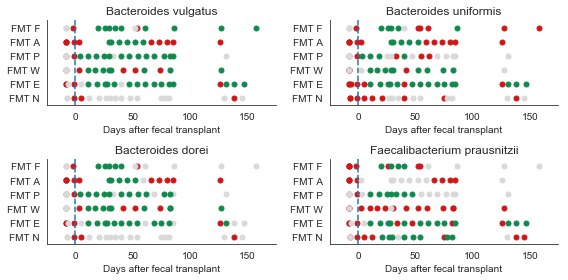

In [55]:
#plot stronger engrafters

ncbi_induc_match_dfs_eng = [ncbi_induc_match_dfs[x] for x in [4, 7, 12, 11]]

fig = plt.figure(figsize = (8,4))

counter = 1
for genome, df in ncbi_induc_match_dfs_eng:
    ax = fig.add_subplot(2, 2, counter)
    
    strain_match_plot3(df, axes=ax)

    plt.xlabel('Days after fecal transplant')
    plt.title(genome_dict[genome])
    
    counter += 1

plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_engrafters_2019-04-13.pdf',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_engrafters_2019-04-13.png',
            dpi=300)

#### Things of note here

1. patient 011 seems to have a bunch of temporary engraftment of species, which are then lost.

2. Patient 010 seems to have a number of strains become dominantely from the donor, and then revert to a mixed community. 

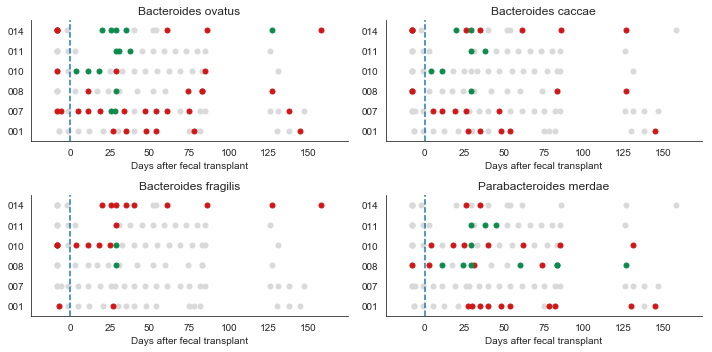

In [97]:
#plot weak engrafters

ncbi_induc_match_dfs_weak = [ncbi_induc_match_dfs[x] for x in [15, 16, 5, 10]]

fig = plt.figure(figsize = (10,5))

counter = 1
for genome, df in ncbi_induc_match_dfs_weak:
    ax = fig.add_subplot(2, 2, counter)
    
    strain_match_plot2(df, axes=ax)

    plt.xlabel('Days after fecal transplant')
    plt.title(genome_dict[genome])
    
    counter += 1

plt.tight_layout()
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_pengraft_NV272018.pdf')
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_pengraft_NV272018.png',
            dpi=300)

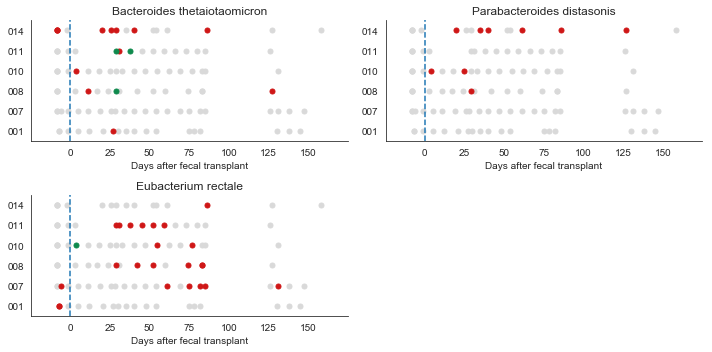

In [98]:
#plot weak engrafters

ncbi_induc_match_dfs_patch = [ncbi_induc_match_dfs[x] for x in [1, 8, 9]]

fig = plt.figure(figsize = (10,5))

counter = 1
for genome, df in ncbi_induc_match_dfs_patch:
    ax = fig.add_subplot(2, 2, counter)
    
    strain_match_plot2(df, axes=ax)

    plt.xlabel('Days after fecal transplant')
    plt.title(genome_dict[genome])
    
    counter += 1

plt.tight_layout()
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_noengraft_NV272018.pdf')
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_noengraft_NV272018.png',
            dpi=300)

## FMT switch samples

In [100]:
#identify strain matches with these dataframes
ncbi_switch_match_dfs = [[x, strain_match_wrap2(y, switch_pairs)] for x, y in ncbi_data_dfs]

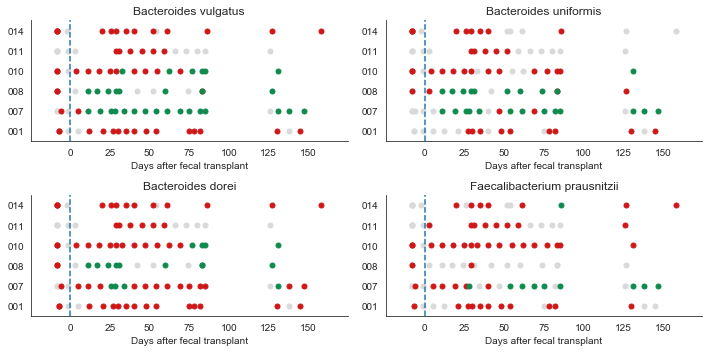

In [102]:
#plot stronger engrafters

ncbi_switch_match_dfs_eng = [ncbi_switch_match_dfs[x] for x in [4, 7, 12, 11]]

fig = plt.figure(figsize = (10,5))

counter = 1
for genome, df in ncbi_switch_match_dfs_eng:
    ax = fig.add_subplot(2, 2, counter)
    
    strain_match_plot2(df, axes=ax)

    plt.xlabel('Days after fecal transplant')
    plt.title(genome_dict[genome])
    
    counter += 1

plt.tight_layout()

#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_engrafters_NV272018.pdf')
#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_engrafters_NV272018.png',
#            dpi=300)

So it actually looks like we can see some real dynamics here of the switching bacteria also engrafting.

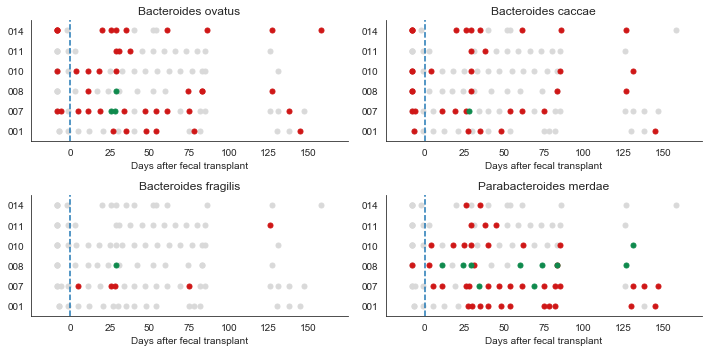

In [103]:
#plot weak engrafters

ncbi_switch_match_dfs_weak = [ncbi_switch_match_dfs[x] for x in [15, 16, 5, 10]]

fig = plt.figure(figsize = (10,5))

counter = 1
for genome, df in ncbi_switch_match_dfs_weak:
    ax = fig.add_subplot(2, 2, counter)
    
    strain_match_plot2(df, axes=ax)

    plt.xlabel('Days after fecal transplant')
    plt.title(genome_dict[genome])
    
    counter += 1

plt.tight_layout()
#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_pengraft_NV272018.pdf')
#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_pengraft_NV272018.png',
#            dpi=300)

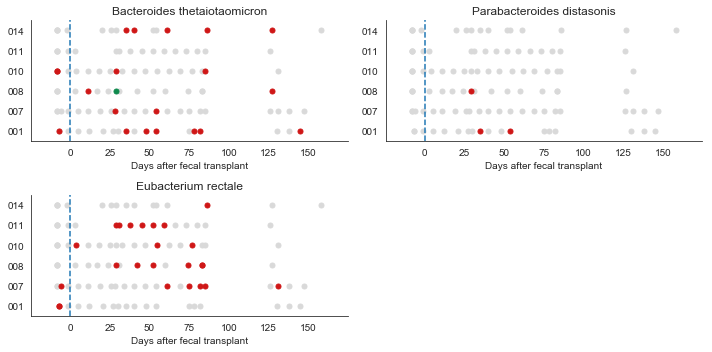

In [104]:
#plot weak engrafters

ncbi_switch_match_dfs_patch = [ncbi_switch_match_dfs[x] for x in [1, 8, 9]]

fig = plt.figure(figsize = (10,5))

counter = 1
for genome, df in ncbi_switch_match_dfs_patch:
    ax = fig.add_subplot(2, 2, counter)
    
    strain_match_plot2(df, axes=ax)

    plt.xlabel('Days after fecal transplant')
    plt.title(genome_dict[genome])
    
    counter += 1

plt.tight_layout()
#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_noengraft_NV272018.pdf')
#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_noengraft_NV272018.png',
#            dpi=300)

## FMT baseline samples


In [106]:
#identify strain matches with these dataframes
ncbi_blfmt_match_dfs = [[x, strain_match_wrap2(y, baseline_fmt_pairs)] for x, y in ncbi_data_dfs]

In [119]:
#Because we have duplicate samples from each patient, 
#we need to create a new column that captures both the patient and the baseline sample compared
def refmt_flex_df(df):
    #reformat for plotting with multiple samples per patient
    df.loc[:, 'patient_id'] = df['patient']
    df.loc[:, 'patient'] = df['patient_id'] +'_' + df['sample_y']
    return df

ncbi_blfmt_match_dfs = [[x, refmt_flex_df(y)] for x, y in ncbi_blfmt_match_dfs]

In [130]:
def strain_match_plot_multiple(strain_match_df, axes=None):
    """
    Accepts a results dataframe from strain_match_wrap and plots
    Better handles multiple samples per patient and more dense plots
    """
    #add time information to table
    plot_df = strain_match_df.merge(md[['sample_id', 'days_past_fmt']], 
                                    left_on='sample_x', right_on='sample_id')
    
    #get a formatter table for plotting
    plot_df = plot_df.set_index('days_past_fmt')

    #make an index for where to place each patient's timeline
    patients = plot_df['patient'].unique()
    cat_dict = dict(zip(patients, range(1, len(patients) + 1)))
    val_dict = dict(zip(range(1, len(patients) + 1), patients))

    #get plotting row
    plot_df['row_num'] = plot_df['patient'].apply(cat_dict.get)
    
    #plot, using the x value as the time, the y value as the patient, and the thresh as the color
    if not axes:
        fig, axes = plt.subplots()
    
    #first plot the ambiguous points
    amb_df = plot_df.loc[plot_df['median_thresh'] == 0]
    if not amb_df.empty:
        amb_df['row_num'].plot(ax=axes, markersize=5, 
                               color='#d9d9d9', linestyle="None", 
                               marker='o')
    #now plot the false points
    false_df = plot_df.loc[plot_df['median_thresh'] == -1]
    if not false_df.empty:
        false_df['row_num'].plot(ax=axes, color='#cf1717', 
                                 markersize=5, marker='o',
                                linestyle="None")
    #now true points
    true_df = plot_df.loc[plot_df['median_thresh'] == 1]
    if not true_df.empty:
        true_df['row_num'].plot(ax=axes, color='#0f8a4d', 
                                markersize=5, marker='o',
                                linestyle="None")
    
    #pad axes
    axes.margins(0.1)
    
    #axes.set_xticklabels([])
    
    # format y-ticks look up the categories
    axes.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: val_dict.get(x)))
    plt.locator_params(axis='y', nbins=17)
    y_ticks = axes.yaxis.get_major_ticks()
    y_ticks[0].label1.set_visible(False)
    y_ticks[-1].label1.set_visible(False)
    
    #add vertical lines for fmt
    axes.axvline(0, linestyle='--')
    
    sns.despine()

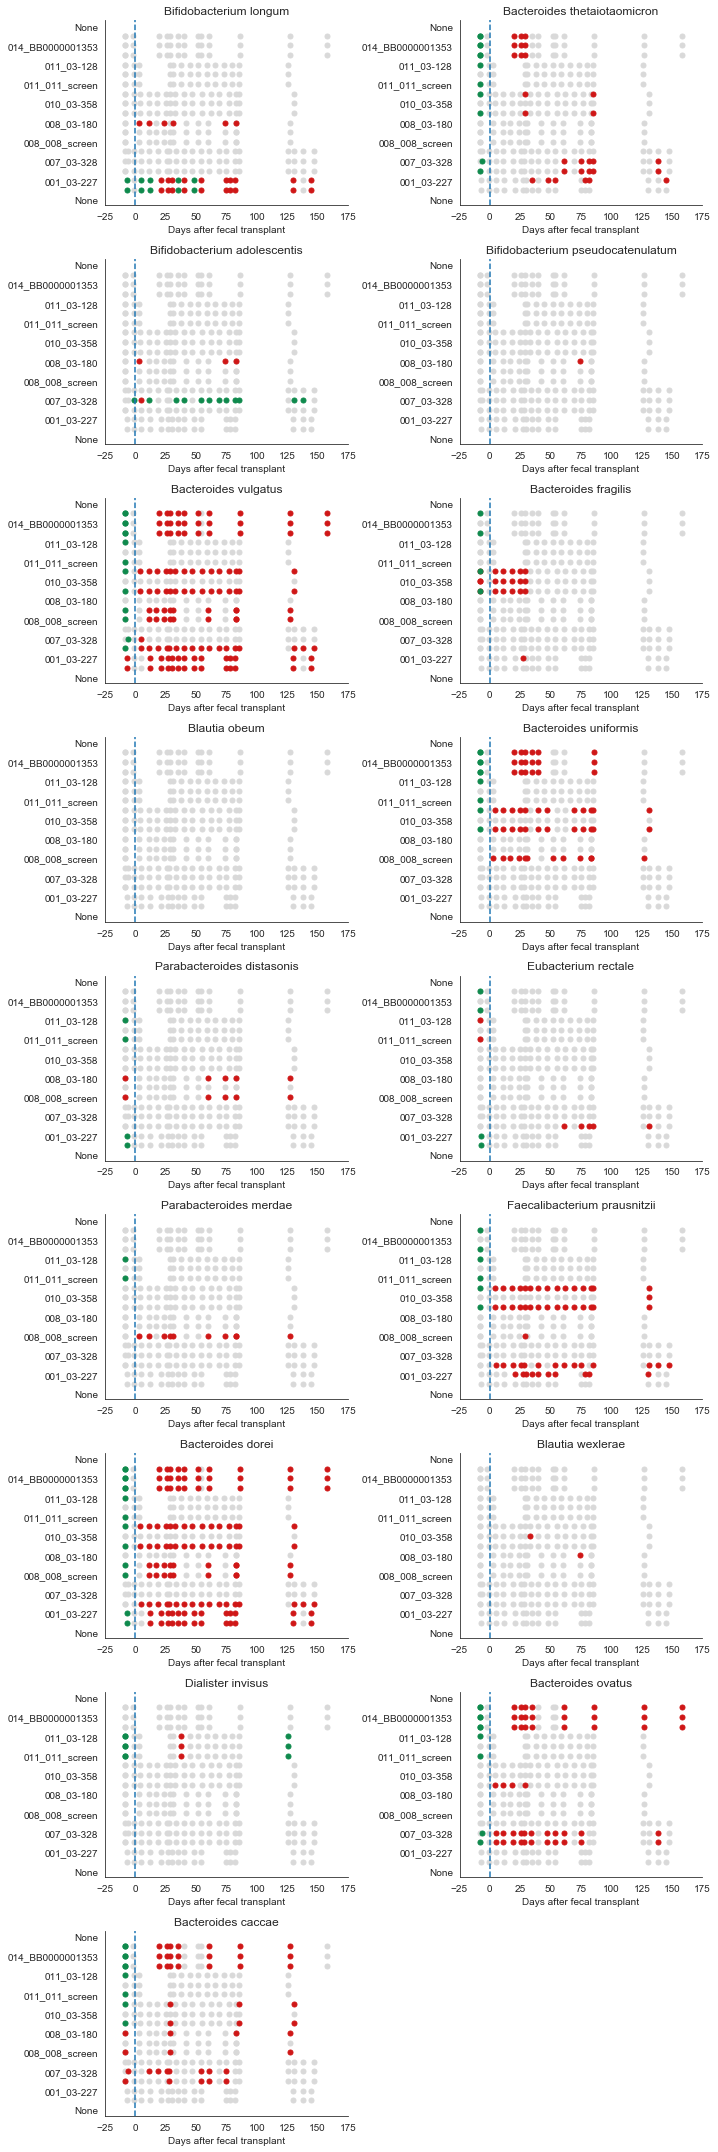

In [131]:
#plot all for baseline comparisons
fig = plt.figure(figsize = (10,30))

counter = 1
for genome, df in ncbi_blfmt_match_dfs:
    ax = fig.add_subplot(9, 2, counter)
    
    #remove same sample comparisons
    df = df.loc[df['sample_x'] != df['sample_y']]
    
    #plot
    strain_match_plot_multiple(df, axes=ax)

    plt.xlabel('Days after fecal transplant')
    plt.title(genome_dict[genome])
    
    counter += 1

plt.tight_layout()

#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_engrafters_NV272018.pdf')
#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_engrafters_NV272018.png',
#            dpi=300)

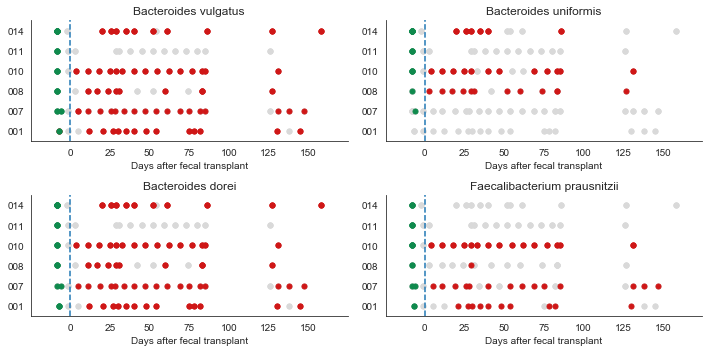

In [114]:
#plot all applicable

ncbi_blfmt_match_dfs_eng = [ncbi_blfmt_match_dfs[x] for x in [4, 7, 12, 11]]

fig = plt.figure(figsize = (10,5))

counter = 1
for genome, df in ncbi_blfmt_match_dfs_eng:
    ax = fig.add_subplot(2, 2, counter)
    
    strain_match_plot2(df, axes=ax)

    plt.xlabel('Days after fecal transplant')
    plt.title(genome_dict[genome])
    
    counter += 1

plt.tight_layout()

#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_engrafters_NV272018.pdf')
#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_engrafters_NV272018.png',
#            dpi=300)

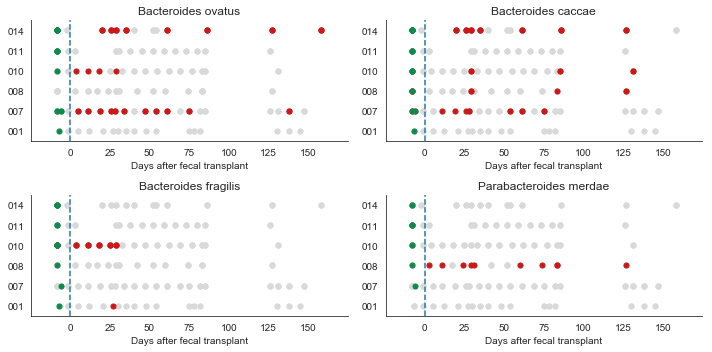

In [108]:
#plot weak engrafters

ncbi_blfmt_match_dfs_weak = [ncbi_blfmt_match_dfs[x] for x in [15, 16, 5, 10]]

fig = plt.figure(figsize = (10,5))

counter = 1
for genome, df in ncbi_blfmt_match_dfs_weak:
    ax = fig.add_subplot(2, 2, counter)
    
    strain_match_plot2(df, axes=ax)

    plt.xlabel('Days after fecal transplant')
    plt.title(genome_dict[genome])
    
    counter += 1

plt.tight_layout()
#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_pengraft_NV272018.pdf')
#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_pengraft_NV272018.png',
#            dpi=300)

### Plot placebo

In [ ]:
import pandas as pd
import subprocess

md = pd.read_csv('/home/ubuntu/users/ndchu/deepdive/metadata/metadata_stooldna_SP192018.tsv',
                 sep='\t')

transfer_samples = md.loc[md['patient'].isin(['0044', 
                                              '0073', 
                                              '007', 
                                              '011'])]['sample_id'].values

fq_dir = '/home/ubuntu/users/ndchu/deepdive/metagenomics/fastq_nonhuman'

for sample in transfer_samples:
    cmd1 = ['aws', 's3', 'cp', 
           f'{fq_dir}/{sample}_paired_aln_human_unmap_1.fastq.gz', 
           's3://almlab.collaborator/quince/']
    cmd2 = ['aws', 's3', 'cp', 
           f'{fq_dir}/{sample}_paired_aln_human_unmap_2.fastq.gz', 
           's3://almlab.collaborator/quince/']
    #print(cmd1)
    subprocess.run(cmd1)
    subprocess.run(cmd2)

## Scaling dots by abundance

Let's figure out how to make the size of the dots scale with the median read depth. We have to consider that we need to make sure that every median read depth calculation takes into account the entire genome.

We'll start testing with F. prausnitzii

In [ ]:
#identify strain matches with these dataframes
ncbi_induc_match_dfs = [[x, strain_match_wrap2(y, induction_pairs)] for x, y in ncbi_data_dfs]

In [132]:
#let's first get the median read depth for all dataframes
#and we'll do this for both samples (x, y)
ncbi_induc_match_med_dfs = []
for x, y in zip(ncbi_data_dfs, ncbi_induc_match_dfs):
    if x[0] != y[0]:
        print('mismatch')
        continue
    #what are the total number of positions in the genome?
    n_kmers = x[1][['contig', 'k_idx']].drop_duplicates().shape[0]
    #get the mean median depth per sample
    med_depth = x[1].groupby('sample_id')['median_read_depth'].sum()
    med_depth = med_depth / n_kmers
    #merge this information back into the df for both samples x and y
    med_depth_x = med_depth.reset_index().rename(columns={'median_read_depth': 'median_read_depth_x'})
    med_depth_y = med_depth.reset_index().rename(columns={'median_read_depth': 'median_read_depth_y'})
    induc_match_df = y[1].merge(med_depth_x, 
                                left_on='sample_x', 
                                right_on='sample_id')
    induc_match_df = induc_match_df.merge(med_depth_y, 
                                left_on='sample_y', 
                                right_on='sample_id')
    induc_match_df = induc_match_df.drop(['sample_id_x', 'sample_id_y'], axis=1)
    ncbi_induc_match_med_dfs.append([x[0], induc_match_df])

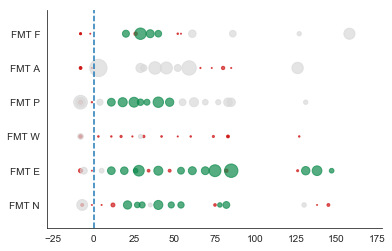

In [81]:
fig, axes = plt.subplots()
strain_match_df = ncbi_induc_match_med_dfs[-6][1]
plot_df = strain_match_df.merge(md[['sample_id', 'days_past_fmt']], 
                                left_on='sample_x', right_on='sample_id')

#get a formatter table for plotting
plot_df = plot_df.set_index('days_past_fmt')

#make an index for where to place each patient's timeline
patients = plot_df['patient'].unique()
ids = [patient_ids[x] for x in patients]
cat_dict = dict(zip(patients, range(1, len(patients) + 1)))
val_dict = dict(zip(range(1, len(patients) + 1), ids))

#get plotting row
plot_df['row_num'] = plot_df['patient'].apply(cat_dict.get)

#plot, using the x value as the time, the y value as the patient, and the thresh as the color
if not axes:
    fig, axes = plt.subplots()

#add a column for the scaled median read depths
plot_df.loc[:, 'scaled_read_depth_x'] = preproc.minmax_scale(plot_df['median_read_depth_x'],
                                                           feature_range=(1, 300))
plot_df.loc[:, 'scaled_read_depth_y'] = preproc.minmax_scale(plot_df['median_read_depth_y'],
                                                           feature_range=(1, 300))
#add a column that is the min of these two columns, for when the strain is absent
plot_df.loc[:, 'scaled_read_depth_min'] = plot_df[['scaled_read_depth_x', 
                                                   'scaled_read_depth_y']].min(axis=1)

#first plot the false points (absent, no reads)
false_df = plot_df.loc[plot_df['median_thresh'] == 0]
if not false_df.empty:
    plt.scatter(false_df.index, false_df['row_num'], 
                s=false_df['scaled_read_depth_min'], c='#cf1717', alpha=0.7)
#now plot the ambiguous points (reads, no match)
amb_df = plot_df.loc[plot_df['median_thresh'] == -1]
if not amb_df.empty:
    plt.scatter(amb_df.index, amb_df['row_num'], 
                s=amb_df['scaled_read_depth_x'], c='#d9d9d9', alpha=0.7)
#now true points, strain match
true_df = plot_df.loc[plot_df['median_thresh'] == 1]
if not true_df.empty:
    plt.scatter(true_df.index, true_df['row_num'], 
                s=true_df['scaled_read_depth_x'], c='#0f8a4d', alpha=0.7)

#pad axes
axes.margins(0.1)

#axes.set_xticklabels([])

# format y-ticks look up the categories
axes.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: val_dict.get(x)))
#y_ticks = axes.yaxis.get_major_ticks()
#y_ticks[0].label1.set_visible(False)
#y_ticks[-1].label1.set_visible(False)
#plt.locator_params(axis='y', nbins=6)

#add vertical lines for fmt
axes.axvline(0, linestyle='--')

sns.despine()

In [23]:
#define a dictionary of patient names
patient_ids = md_pat.set_index('patient').to_dict()['label_pub']

def strain_match_plot4(strain_match_df, axes=None):
    """
    Accepts a results dataframe from strain_match_wrap that also
    contains the median read depths per sample and plots
    
    Green = strain match
    Red = bacteria absent
    Grey = strain identity ambiguous
    
    It additionally scales the size of the markers to reflect the 
    mean read depth in each sample
    """
    #add time information to table
    plot_df = strain_match_df.merge(md[['sample_id', 'days_past_fmt']], 
                                    left_on='sample_x', right_on='sample_id')
    
    #get a formatter table for plotting
    plot_df = plot_df.set_index('days_past_fmt')

    #make an index for where to place each patient's timeline
    patients = plot_df['patient'].unique()
    ids = [patient_ids[x] for x in patients]
    cat_dict = dict(zip(patients, range(1, len(patients) + 1)))
    val_dict = dict(zip(range(1, len(patients) + 1), ids))

    #get plotting row
    plot_df['row_num'] = plot_df['patient'].apply(cat_dict.get)

    #plot, using the x value as the time, the y value as the patient, and the thresh as the color
    if not axes:
        fig, axes = plt.subplots()

    #add a column for the scaled median read depths of the patient sample
    plot_df.loc[:, 'scaled_read_depth_x'] = preproc.minmax_scale(plot_df['median_read_depth_x'],
                                                                 feature_range=(1, 300))
    #add a column that is the min of patient and comparison sample
    #min_med_depth = plot_df[['median_read_depth_x', 'median_read_depth_y']].min(axis=1)
    #X_std = (min_med_depth - min_med_depth.min()) / \
    #        (plot_df['median_read_depth_x'].max() - min_med_depth.min())
    #X_scaled = X_std * (300 - 1) + 1
    #plot_df.loc[:, 'scaled_read_depth_min'] = X_scaled
    
    #add graph regions
    ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
    ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

    #first plot the false points (absent, no reads)
    false_df = plot_df.loc[plot_df['median_thresh'] == 0]
    if not false_df.empty:
        plt.scatter(false_df.index, false_df['row_num'], 
                    s=2, #signifies insufficient reads
                    c='#cf1717', alpha=0.8)
    #now plot the ambiguous points (reads, no match)
    amb_df = plot_df.loc[plot_df['median_thresh'] == -1]
    if not amb_df.empty:
        plt.scatter(amb_df.index, amb_df['row_num'], 
                    s=amb_df['scaled_read_depth_x'], 
                    c='#d9d9d9', alpha=0.8)
    #now true points, strain match
    true_df = plot_df.loc[plot_df['median_thresh'] == 1]
    if not true_df.empty:
        plt.scatter(true_df.index, true_df['row_num'], 
                    s=true_df['scaled_read_depth_x'], 
                    c='#0f8a4d', alpha=0.8)
    
    #pad axes
    axes.margins(0.1)

    #axes.set_xticklabels([])

    # format y-ticks look up the categories
    axes.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: val_dict.get(x)))
    #y_ticks = axes.yaxis.get_major_ticks()
    #y_ticks[0].label1.set_visible(False)
    #y_ticks[-1].label1.set_visible(False)
    plt.locator_params(axis='y', nbins=6)

    #add vertical lines for fmt
    axes.axvline(0, linestyle='--')

    sns.despine()

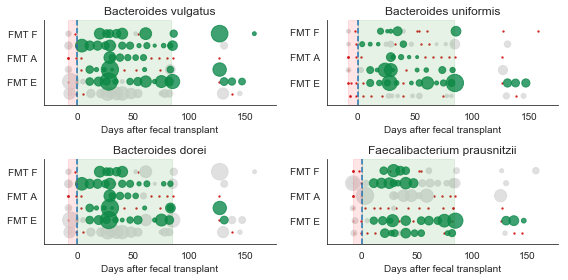

In [170]:
#plot stronger engrafters

ncbi_induc_match_dfs_eng = [ncbi_induc_match_med_dfs[x] for x in [4, 7, 12, 11]]

fig = plt.figure(figsize = (8,4))

counter = 1
for genome, df in ncbi_induc_match_dfs_eng:
    ax = fig.add_subplot(2, 2, counter)
    
    strain_match_plot4(df, axes=ax)

    plt.xlabel('Days after fecal transplant')
    plt.title(genome_dict[genome])
    
    counter += 1

plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_engrafters_2019-04-24.pdf',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_engrafters_2019-04-24.png',
            dpi=300)

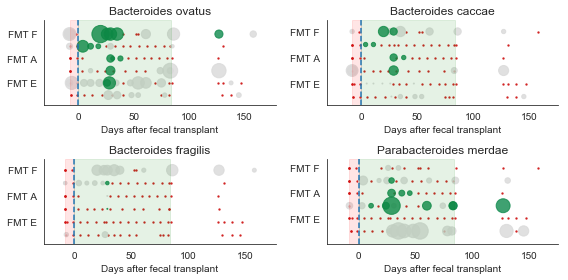

In [171]:
#plot weak engrafters

ncbi_induc_match_dfs_weak = [ncbi_induc_match_med_dfs[x] for x in [15, 16, 5, 10]]

fig = plt.figure(figsize = (8,4))

counter = 1
for genome, df in ncbi_induc_match_dfs_weak:
    ax = fig.add_subplot(2, 2, counter)
    
    strain_match_plot4(df, axes=ax)

    plt.xlabel('Days after fecal transplant')
    plt.title(genome_dict[genome])
    
    counter += 1

plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_weak_2019-04-24.pdf',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strainmatch_weak_2019-04-24.png',
            dpi=300)

### Get plots for baseline comparisons

In [19]:
#identify strain matches with these dataframes
ncbi_blfmt_match_dfs = [[x, strain_match_wrap2(y, baseline_fmt_pairs)] for x, y in ncbi_data_dfs]

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [26]:
gens = [x[0] for x in ncbi_blfmt_match_dfs]
genome_dict = {k: ' '.join(k.split('_')[:2]).capitalize() for k in gens}

In [21]:
#let's first get the median read depth for all dataframes
#and we'll do this for both samples (x, y)
ncbi_blfmt_match_med_dfs = []
for x, y in zip(ncbi_data_dfs, ncbi_blfmt_match_dfs):
    if x[0] != y[0]:
        print('mismatch')
        continue
    #what are the total number of positions in the genome?
    n_kmers = x[1][['contig', 'k_idx']].drop_duplicates().shape[0]
    #get the mean median depth per sample
    med_depth = x[1].groupby('sample_id')['median_read_depth'].sum()
    med_depth = med_depth / n_kmers
    #merge this information back into the df for both samples x and y
    med_depth_x = med_depth.reset_index().rename(columns={'median_read_depth': 'median_read_depth_x'})
    med_depth_y = med_depth.reset_index().rename(columns={'median_read_depth': 'median_read_depth_y'})
    blfmt_match_df = y[1].merge(med_depth_x, 
                                left_on='sample_x', 
                                right_on='sample_id')
    blfmt_match_df = blfmt_match_df.merge(med_depth_y, 
                                left_on='sample_y', 
                                right_on='sample_id')
    blfmt_match_df = blfmt_match_df.drop(['sample_id_x', 'sample_id_y'], axis=1)
    ncbi_blfmt_match_med_dfs.append([x[0], blfmt_match_df])

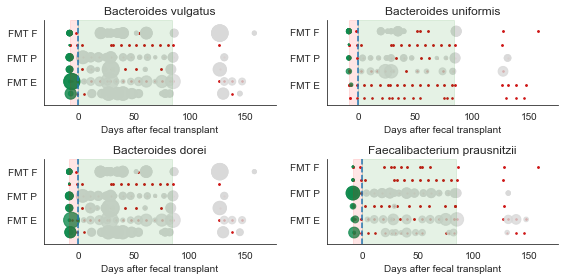

In [27]:
#plot stronger engrafters

ncbi_blfmt_match_dfs_eng = [ncbi_blfmt_match_med_dfs[x] for x in [4, 7, 12, 11]]

fig = plt.figure(figsize = (8,4))

counter = 1
for genome, df in ncbi_blfmt_match_dfs_eng:
    ax = fig.add_subplot(2, 2, counter)
    
    strain_match_plot4(df, axes=ax)

    plt.xlabel('Days after fecal transplant')
    plt.title(genome_dict[genome])
    
    counter += 1

plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strmtch_eng_blfmt_2019-05-05.pdf',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strmtch_eng_blfmt_2019-05-05.png',
            dpi=300)

## Get plots for placebo to donors

In [28]:
#identify strain matches with these dataframes
ncbi_plcdnr_match_dfs = [[x, strain_match_wrap2(y, controls)] for x, y in ncbi_data_dfs]

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [35]:
#let's first get the median read depth for all dataframes
#and we'll do this for both samples (x, y)
ncbi_plcdnr_match_med_dfs = []
for x, y in zip(ncbi_data_dfs, ncbi_plcdnr_match_dfs):
    if x[0] != y[0]:
        print('mismatch')
        continue
    #what are the total number of positions in the genome?
    n_kmers = x[1][['contig', 'k_idx']].drop_duplicates().shape[0]
    #get the mean median depth per sample
    med_depth = x[1].groupby('sample_id')['median_read_depth'].sum()
    med_depth = med_depth / n_kmers
    #merge this information back into the df for both samples x and y
    med_depth_x = med_depth.reset_index().rename(columns={'median_read_depth': 'median_read_depth_x'})
    med_depth_y = med_depth.reset_index().rename(columns={'median_read_depth': 'median_read_depth_y'})
    plcdnr_match_df = y[1].merge(med_depth_x, 
                                left_on='sample_x', 
                                right_on='sample_id')
    plcdnr_match_df = plcdnr_match_df.merge(med_depth_y, 
                                left_on='sample_y', 
                                right_on='sample_id')
    plcdnr_match_df = plcdnr_match_df.drop(['sample_id_x', 'sample_id_y'], axis=1)
    ncbi_plcdnr_match_med_dfs.append([x[0], plcdnr_match_df])

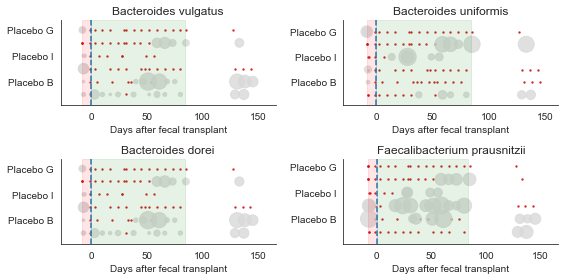

In [36]:
#plot stronger engrafters

ncbi_plcdnr_match_med_dfs_eng = [ncbi_plcdnr_match_med_dfs[x] for x in [4, 7, 12, 11]]

fig = plt.figure(figsize = (8,4))

counter = 1
for genome, df in ncbi_plcdnr_match_med_dfs_eng:
    ax = fig.add_subplot(2, 2, counter)
    
    strain_match_plot4(df, axes=ax)

    plt.xlabel('Days after fecal transplant')
    plt.title(genome_dict[genome])
    
    counter += 1

plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_plcdnr_eng_2019-05-05.pdf',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_plcdnr_eng_2019-05-05.png',
            dpi=300)

## Get plots for placebo to baseline

In [37]:
#identify strain matches with these dataframes
ncbi_plcbl_match_dfs = [[x, strain_match_wrap2(y, baseline_plc_pairs)] for x, y in ncbi_data_dfs]

Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results


/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results


/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one

Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one

Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one

Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one of the input dataframes is empty. Do not trust results
Error: one

In [38]:
#let's first get the median read depth for all dataframes
#and we'll do this for both samples (x, y)
ncbi_plcbl_match_med_dfs = []
for x, y in zip(ncbi_data_dfs, ncbi_plcbl_match_dfs):
    if x[0] != y[0]:
        print('mismatch')
        continue
    #what are the total number of positions in the genome?
    n_kmers = x[1][['contig', 'k_idx']].drop_duplicates().shape[0]
    #get the mean median depth per sample
    med_depth = x[1].groupby('sample_id')['median_read_depth'].sum()
    med_depth = med_depth / n_kmers
    #merge this information back into the df for both samples x and y
    med_depth_x = med_depth.reset_index().rename(columns={'median_read_depth': 'median_read_depth_x'})
    med_depth_y = med_depth.reset_index().rename(columns={'median_read_depth': 'median_read_depth_y'})
    plcbl_match_df = y[1].merge(med_depth_x, 
                                left_on='sample_x', 
                                right_on='sample_id')
    plcbl_match_df = plcbl_match_df.merge(med_depth_y, 
                                left_on='sample_y', 
                                right_on='sample_id')
    plcbl_match_df = plcbl_match_df.drop(['sample_id_x', 'sample_id_y'], axis=1)
    ncbi_plcbl_match_med_dfs.append([x[0], plcbl_match_df])

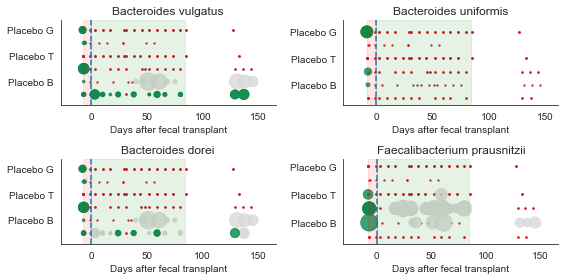

In [39]:
#plot stronger engrafters

ncbi_plcbl_match_med_dfs_eng = [ncbi_plcbl_match_med_dfs[x] for x in [4, 7, 12, 11]]

fig = plt.figure(figsize = (8,4))

counter = 1
for genome, df in ncbi_plcbl_match_med_dfs_eng:
    ax = fig.add_subplot(2, 2, counter)
    
    strain_match_plot4(df, axes=ax)

    plt.xlabel('Days after fecal transplant')
    plt.title(genome_dict[genome])
    
    counter += 1

plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_plcbl_eng_2019-05-05.pdf',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_plcbl_eng_2019-05-05.png',
            dpi=300)

## Get plots for switch donor samples

In [41]:
#identify strain matches with these dataframes
ncbi_switch_match_dfs = [[x, strain_match_wrap2(y, switch_pairs)] for x, y in ncbi_data_dfs]

In [42]:
#let's first get the median read depth for all dataframes
#and we'll do this for both samples (x, y)
ncbi_swtich_match_med_dfs = []
for x, y in zip(ncbi_data_dfs, ncbi_switch_match_dfs):
    if x[0] != y[0]:
        print('mismatch')
        continue
    #what are the total number of positions in the genome?
    n_kmers = x[1][['contig', 'k_idx']].drop_duplicates().shape[0]
    #get the mean median depth per sample
    med_depth = x[1].groupby('sample_id')['median_read_depth'].sum()
    med_depth = med_depth / n_kmers
    #merge this information back into the df for both samples x and y
    med_depth_x = med_depth.reset_index().rename(columns={'median_read_depth': 'median_read_depth_x'})
    med_depth_y = med_depth.reset_index().rename(columns={'median_read_depth': 'median_read_depth_y'})
    switch_match_df = y[1].merge(med_depth_x, 
                                left_on='sample_x', 
                                right_on='sample_id')
    switch_match_df = switch_match_df.merge(med_depth_y, 
                                left_on='sample_y', 
                                right_on='sample_id')
    switch_match_df = switch_match_df.drop(['sample_id_x', 'sample_id_y'], axis=1)
    ncbi_swtich_match_med_dfs.append([x[0], switch_match_df])

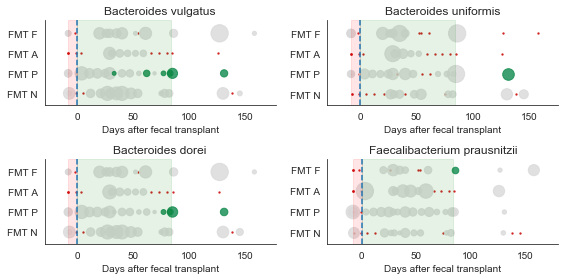

In [43]:
#plot stronger engrafters

ncbi_switch_match_dfs_eng = [ncbi_swtich_match_med_dfs[x] for x in [4, 7, 12, 11]]

fig = plt.figure(figsize = (8,4))

counter = 1
for genome, df in ncbi_switch_match_dfs_eng:
    ax = fig.add_subplot(2, 2, counter)
    
    strain_match_plot4(df, axes=ax)

    plt.xlabel('Days after fecal transplant')
    plt.title(genome_dict[genome])
    
    counter += 1

plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strmtch_eng_switch_2019-05-05.pdf',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/flex_gen_strmtch_eng_switch_2019-05-05.png',
            dpi=300)